# Bi-LSTM

In [1]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
dataset_directory = '/content/drive/MyDrive/Datasets/DATA/Data.zip'
zip_ref = zipfile.ZipFile(dataset_directory, 'r')
zip_ref.extractall('10K_Dataset')

# Imports


In [3]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import re
import numpy as np
import time
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import itertools
import csv
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import spacy
from sklearn.manifold import TSNE

from gensim.models.phrases import Phrases, Phraser
import logging
import gensim
from gensim.models import Word2Vec
import multiprocessing
# from gensim.models.wrappers import FastText
from gensim.models import fasttext as ftext
from gensim.test.utils import datapath
from torch.utils.data import Dataset, DataLoader


from torch.autograd import Variable
from torch.nn.parameter import Parameter
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report
import random


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
from torch.nn.parameter import Parameter

random.seed(50)

In [4]:
EXPERIMENT_NAME = "bi-lstm"
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Saved Models")
LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

In [5]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.comment = X
        self.label = y
        # self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        self.length = [ len(x) for x in X]
        
    def __getitem__(self, index):
        x = self.comment[index]
        y = self.label[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.comment)




class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):

        print(type(self.sentences))
        self.vocab.update(self.sentences)
            
        # sort the vocab
        self.vocab = sorted(self.vocab)
#         print(self.vocab)
        

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            if word == self.vocab[-1]:
                self.word2idx[word] = 0
            else:
                self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word


class LSTM_Attn_Sentiment(torch.nn.Module):
    def __init__(self,  vocab_size, embedding_matrix, embedding_dim, batch_size, output_size, hidden_size, n_layers, bidirectional,
                  dropout, NUM_FILTERS =10, window_sizes=(1,2,3,5)):
      super(LSTM_Attn_Sentiment, self).__init__()
      
      """
      Arguments
      ---------
      batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
      output_size : 2 = (pos, neg)
      hidden_sie : Size of the hidden_state of the LSTM
      vocab_size : Size of the vocabulary containing unique words
      embedding_length : Embeddding dimension of GloVe word embeddings
      weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
      
      --------
      return : logits, sentence embedding
      """
      
      
      self.batch_size = batch_size
      self.output_size = output_size
      self.hidden_size = hidden_size
      self.n_layers = n_layers
      

      
      # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix)) //Pretrained
      self.embedding = nn.Embedding(vocab_size, embedding_dim) 


      self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers = n_layers, bidirectional = True,  batch_first = True)

      self.attn = Attention(self.hidden_size*2)
      self.dropout = nn.Dropout(dropout)
      self.softmax = nn.Softmax(dim = 1)
      self.label = nn.Linear(hidden_size*2, output_size)


    def forward(self, input_sentences, batch_size=None):

      """ 
      Parameters
      ----------
      input_sentence: input_sentence of shape = (batch_size, num_sequences)
      batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
      
      Returns
      -------
      Output of the linear layer containing logits for pos & neg class which receives its input as the new_hidden_state which is basically the output of the Attention network.
      final_output.shape = (batch_size, output_size)
      
      """
      
      input = self.embedding(input_sentences)

      
   
      if batch_size is None:
        h_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size).cuda())
      else:
        h_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size).cuda())
        
      output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0.detach(), c_0.detach())) # final_hidden_state.size() = (1, batch_size, hidden_size) 

      attn_output = self.attn(output)

      attn_output = self.dropout(attn_output)
      
      logits = self.label(attn_output)
      logits = self.softmax(logits)
      
      
      return logits, input, attn_output


class Attention(nn.Module):
    def __init__(self, dimension):
        super(Attention, self).__init__()
        self.wt = Parameter(torch.Tensor(dimension, dimension))
        self.u = nn.Linear(dimension, dimension)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, h):
      

        x = self.u(h)
       
        x = self.softmax(x)

        
        output = x * h

        output = torch.sum(output, dim=1)

        return output

{'অন্যের', 'হোক', 'অন্যরকম', 'আইন', 'উদগ্রীব', 'যুদ্ধজয়', 'পাঠাও', 'ভয়', 'পারছে', 'তুরস্ক', 'আর', 'মারছো', 'কুত্তাগুলোর', 'বাংলাদেশিসহ', 'ধৈর্য', 'অন্যো', 'বোধগম্য', 'দাগী', 'জীনবদশায়', 'এছাড়াও', 'হটিয়ে', 'কারণেই', 'কমে', 'গতিই', 'ইউক্রেনও', '১৭', 'কলিজা', 'মানতেই', 'মানুষদের', 'ভাড়াতে', 'সেইটার', 'ন্যাটো', 'জড়িয়েই', 'বাংলাদেশিদের', 'গেছি', 'আধূনিক', 'জিতিয়ে', 'চর্চা', 'উস্কানি', 'খাইছে', 'জায়গাও', 'সাগর', 'মানোবতার', 'উসকানি', 'ছায়াযুদ্ধ', 'ভালনা', 'আমেরিকারে', 'সেনাবাহিনীতে', 'ভাগেরি', 'উপায়ে', 'নিলনা', 'ডেটেড', 'বাঙালিদের', 'পাইলেই', 'আইক্কা', 'সারমাতের', 'কাহিনি', 'নিতেন', 'বোঝেনা', 'বেলায়', 'করিনা', 'কাঁপবে', 'উৎখাত', 'যাখ', 'উরাই', 'গার্মেন্টস', 'মুঠোয়', 'সম্পর্কের', 'পাগলটার', 'পারবেন', 'একে', 'সংলাপই', 'ইষটার', 'পুরাতন', 'কতৃত্ব', 'পারফেক্ট', 'জেলেনসকী', 'একটার', 'ক্ষেত্রেও', 'আর্তনাতের', 'দু', 'কেড়ে', 'মাধ্যমও', 'ক্ষমতার', 'পেল', 'মারবে', 'মতই', 'নেশাগ্রস্ত', 'ছেলেকে', 'রানা', 'স্বস্থি', 'পাঠিয়েছে', 'খোর', 'বৃটেন', 'চলতেছে', 'যেটা', 'বলির', 'প্রতারণার', 'বেডায়', 'মোড়লদের'

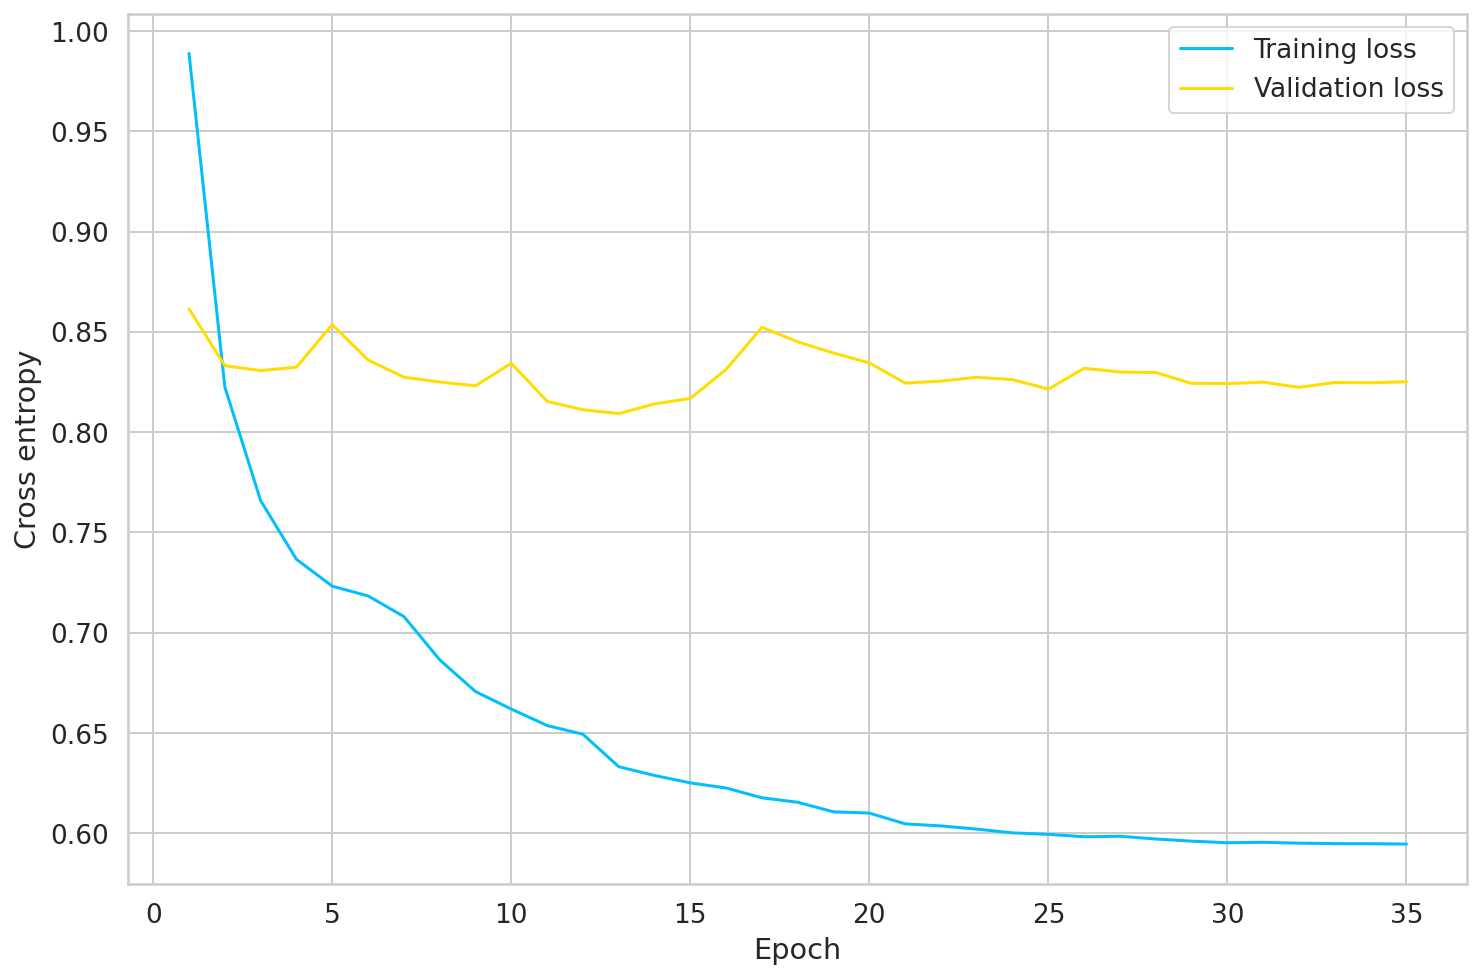

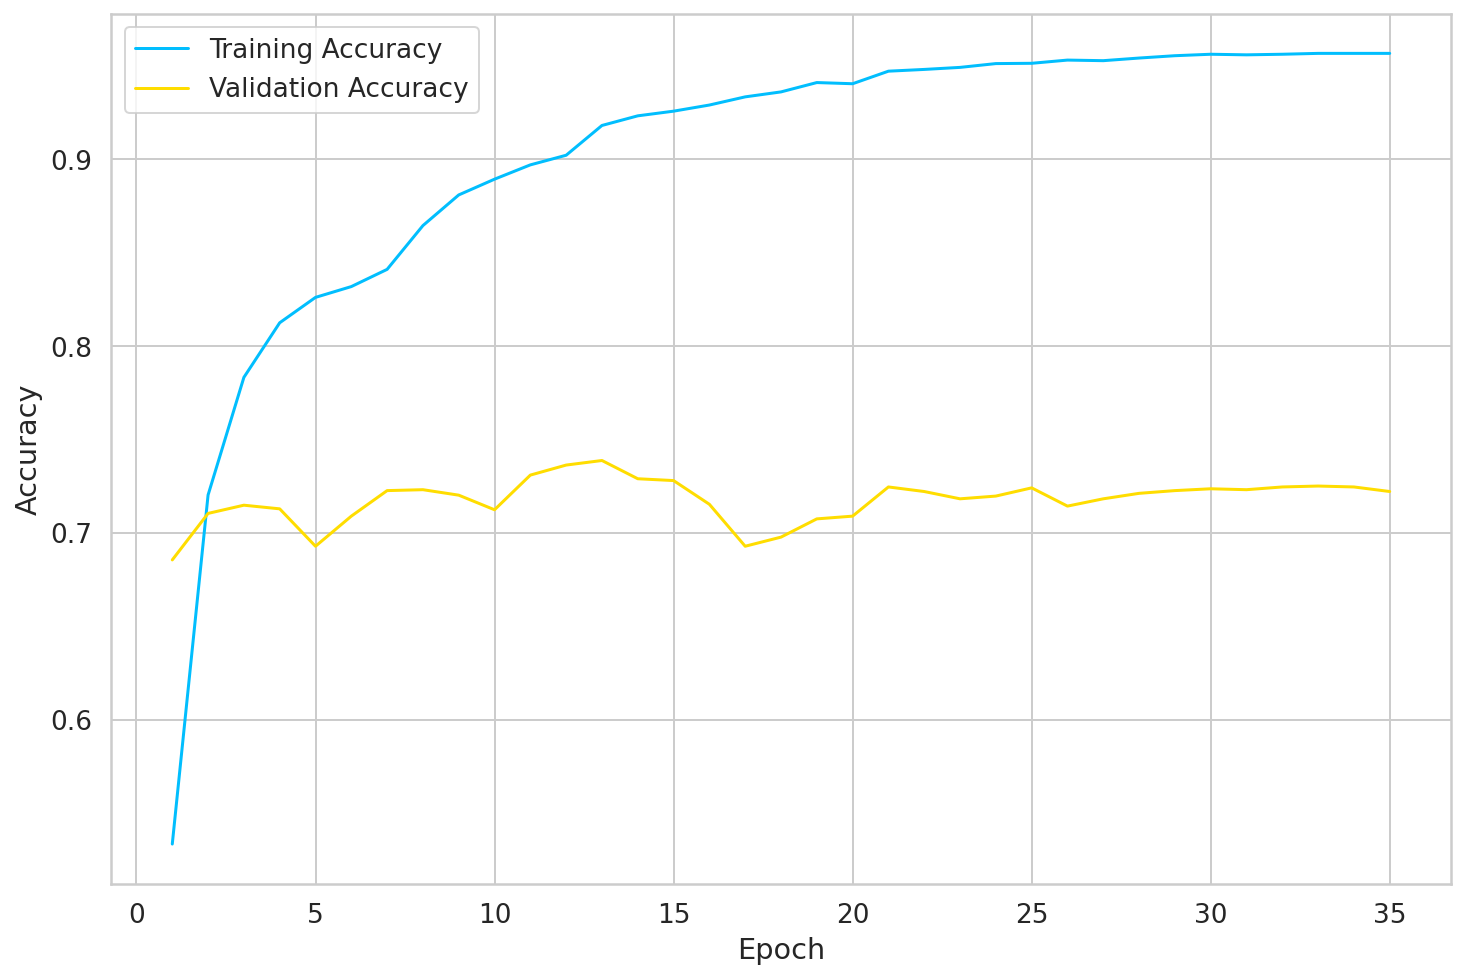

Test Result
tp:  1491
fp:  1116
fn:  557
precision:  57.19
recall:  72.8
f1:  64.06
Test Accuracy:  0.72802734375
Validation Result
tp:  1513
fp:  1156
fn:  535
precision:  56.69
recall:  73.88
f1:  64.15
Val Accuracy:  0.73876953125
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       849
           1       0.55      0.29      0.38       232
           2       0.77      0.81      0.79       967

    accuracy                           0.74      2048
   macro avg       0.68      0.63      0.64      2048
weighted avg       0.73      0.74      0.73      2048



In [6]:
def max_length(tensor):
    return 50




def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded


def dataset_preprocessing():
    weights = 0

    path_parent = os.path.dirname( os.getcwd() )
    os.chdir( path_parent )
    df_train = pd.read_csv( os.getcwd() + "/content/10K_Dataset/Final_Train.csv" )
    df_val =  pd.read_csv( os.getcwd() + "/content/10K_Dataset/Final_Val.csv" )
    df_test = pd.read_csv( os.getcwd() + "/content/10K_Dataset/Final_Test.csv" )
    dictions = pytorch_embedding(df_train)
    inputs = ConstructVocab(dictions)


   
    input_tensor_train, target_tensor_train, num_emotions, iktu, max_length = converting_to_w2v(df_train,inputs, testy = False)
    input_tensor_val, target_tensor_val, num_emotions, iktu, max_length = converting_to_w2v(df_val, inputs, testy= False)
    input_tensor_test, target_tensor_test, num_emotions, iktu, max_length = converting_to_w2v(df_test, inputs, testy = True)



    ###Split data
    
  

    # Show length
    print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test))
    
    
    
    ##Data Loader
    
    TRAIN_BUFFER_SIZE = len(input_tensor_train)
    VAL_BUFFER_SIZE = len(input_tensor_val)
    TEST_BUFFER_SIZE = len(input_tensor_test)
    BATCH_SIZE = 256
    TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
    VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
    TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

    
    vocab_inp_size = len(inputs.word2idx)
    target_size = num_emotions

    
    train_dataset = MyData(input_tensor_train, target_tensor_train)
    val_dataset = MyData(input_tensor_val, target_tensor_val)
    test_dataset = MyData(input_tensor_test, target_tensor_test)

    train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                         drop_last=True,
                         shuffle=False)
    val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                         drop_last=True,
                         shuffle=False)
    test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                         drop_last=True,
                         shuffle=False)
  



    return train_dataset, val_dataset, test_dataset, input_tensor_train, input_tensor_val, input_tensor_test, weights, vocab_inp_size, inputs, max_length
    

def pytorch_embedding(df):
  vocabs = set()
  corpus = df.Comment.to_list()
  for sentences in corpus:
    vocabs.update(sentences.split())

  print(vocabs)
  dict_vocab = {}
  for index, word in enumerate(vocabs):
    
    dict_vocab[word] = index

  return dict_vocab


def converting_to_w2v(data, inputs, testy):
  
  
  ##Taking control of the unknown word
  
  input_tensor1 = []

  for es in data["Comment"].values.tolist():
    
    temp = []
    for s in es.split():
      try:
        temp.append(inputs.word2idx[s])
      except:
        temp.append(0)
      temp.append(0)
    
    input_tensor1.append(temp)
  
  
  max_length_inp = max_length(input_tensor1)
  

  
  
  input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor1]


  

  
  ### convert targets to one-hot encoding vectors
  emotions = list(set(data.Label.unique()))
  num_emotions = len(emotions)

  
  
  target_tensor = data.Label.to_numpy()

  return input_tensor, target_tensor, num_emotions, input_tensor1, max_length_inp


def create_model(weights, vocab_size):
  """
  Initializes the model
  Moves to GPU if found any

  Return: the model
  """
  print("vocab_size: ",vocab_size)
  embedding_dim = 300
  dropout = 0.3
  bidirectional = True
  n_layers = 2
  units = 100
  BATCH_SIZE = 256
  target_size = 3

  model = LSTM_Attn_Sentiment(vocab_size, weights, embedding_dim, BATCH_SIZE, target_size, units, n_layers, bidirectional, dropout)

  if torch.cuda.is_available():
    model = model.cuda()

  return model, embedding_dim, units

def accuracy(acc_targ, acc_pred):
    acc_tot = 0
    arr = confusion_matrix(acc_targ, acc_pred)
    for k in range(len(acc_targ)):
        if(acc_targ[k] == acc_pred[k]):
            acc_tot += 1
    
    fp = arr[0][1] + arr[0][2] + arr[1][0] + arr[1][2] + arr[2][1] + arr[2][2]
    fn = arr[1][0] + arr[2][0] + arr[0][1] + arr[2][1] + arr[0][2] + arr[1][2]
    tp = arr[0][0] + arr[1][1] + arr[2][2]
    print("tp: ", tp)
    print("fp: ",fp)
    print("fn: ", fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print("precision: ", round(tp/(tp+fp)*100,2) )
    print("recall: ", round(tp/(tp+fn)*100,2) )
    print("f1: ", round( ((2*precision*recall )/(precision+recall) )*100,2) )

            
    return acc_tot/ len(acc_targ)


def train(model, iterator, optimizer, tot_len, max_length, embedding_dim):
    
    epoch_loss = 0
    
    acc_targ = []
    acc_pred = []
    
    model.train()
    word_embedding = torch.empty(((0,max_length, embedding_dim)))
    
    cnt = 0
    
    if(torch.cuda.is_available()):
      word_embedding = word_embedding.cuda()
    
    for (batch, (inp, targ, lens)) in enumerate(iterator):
        
        cnt += 1
        
        if(torch.cuda.is_available()):
            inp = inp.cuda()
            targ = targ.cuda()
        
        optimizer.zero_grad()
        
        
        predictions, input, sentence_embedding = model(inp)

        word_embedding = torch.cat((word_embedding,input),dim = 0)
        

        criterion = nn.CrossEntropyLoss()
        

        loss = criterion(predictions, targ)

        
        
        

        
        loss.backward()
        
        
        optimizer.step()


        
        epoch_loss += loss.data.item()
        
        acc_targ.extend(targ.tolist())

        acc_pred.extend(torch.max(predictions, 1)[1].tolist())
    

    return epoch_loss / len(iterator), acc_targ, acc_pred, word_embedding



def evaluate(model, iterator, tot_len, embedding_dim, inputs, units):
    
    epoch_loss = 0
    acc_targ = []
    acc_pred = []
    index_tensors = []
    
    model.eval()
    
    for_projection = torch.empty((0,units*2))
    
    if(torch.cuda.is_available()):
      for_projection = for_projection.cuda()

    sentences = []

    with torch.no_grad():
      for (batch, (inp, targ, lens)) in enumerate(iterator):

            if(torch.cuda.is_available()):
                inp = inp.cuda()
                targ = targ.cuda()

            predictions, input, sentence_embedding = model(inp)
           
                 
            for_projection = torch.cat((for_projection,sentence_embedding),dim = 0)
           

            criterion = nn.CrossEntropyLoss()
            
            loss = criterion(predictions, targ)           

            for i in range(inp.size(0)):
           
            
              st = ''

            
              for j in range(inp.size(1)):
                
              
                if(inp.cpu().numpy()[i][j] == 0):
                  st += ' '
                else:
                  st += inputs.idx2word[inp.cpu().numpy()[i][j]]
                  
              
              fin_st = ''
              tired = False
              for char in st:
                if(char == ' ' and tired == False):
                  fin_st += ' '
                  tired = True
                elif(char != ' '):
                  fin_st += char
                  tired = False               

             
              sentences.append(fin_st)

            acc_targ.extend(targ.tolist())
           
            acc_pred.extend(torch.max(predictions, 1)[1].tolist())
            index_tensors.extend(torch.max(predictions, 1)[0].tolist())
           
            

            epoch_loss += loss.data.item()
    
    return epoch_loss / len(iterator), acc_targ, acc_pred, for_projection, index_tensors, sentences

def training_loop(train_dataset, val_dataset, input_tensor_train, input_tensor_val,test_dataset, input_tensor_test, weights, vocab_size, inputs, max_len):
    """
    :return:
    """
    start_time = time.time()

    model, embedding_dim, units = create_model(weights, vocab_size)

    optimizer = optim.Adam( model.parameters(), lr=0.01)

    max_epochs = 35

    best_valid_acc = 0

    tr_loss_lst = []
    vl_loss_lst = []
    tr_acc_lst = []
    vl_acc_lst = []


    for epoch in range(max_epochs):

        print('[Epoch %d]' % (epoch + 1))

        train_loss, cnt_targ, cnt_pred, input= train(model, train_dataset, optimizer, len(input_tensor_train), max_len, embedding_dim)
        
        train_acc = accuracy(cnt_targ, cnt_pred)
        
        tr_loss_lst.append(train_loss)
        tr_acc_lst.append(train_acc)

        val_loss, cnt_targ, cnt_pred, _, index_tensors, _ = evaluate(model, val_dataset, len(input_tensor_val), embedding_dim, inputs, units)
        
        val_acc = accuracy(cnt_targ, cnt_pred)

        vl_loss_lst.append(val_loss)
        vl_acc_lst.append(val_acc)





        print('Training Loss %.5f, Validation Loss %.5f' % (train_loss, val_loss))
        print('Training Accuracy %.5f, Validation Accuracy %.5f' % (train_acc, val_acc) )

        



        writer.add_scalars('Loss', {'Train_Loss':train_loss,
                                'Val_loss':val_loss}, epoch)
        
        writer.add_scalars('Accuracy', {'Train_Acc':train_acc,
                        'Val_Acc':val_acc}, epoch)
        

        
        

        if val_acc > best_valid_acc:
          best_valid_acc = val_acc
          torch.save(model.state_dict(), '{}/{}.pth'.format(LOG_PATH, EXPERIMENT_NAME))



        print()
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    
    tr_loss_lst = np.array(tr_loss_lst)
    np.savetxt("{}/{}_train_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), tr_loss_lst, delimiter=",")
    vl_loss_lst = np.array(vl_loss_lst)
    np.savetxt("{}/{}_val_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), vl_loss_lst, delimiter=",")

    tr_acc_lst = np.array(tr_acc_lst)
    np.savetxt("{}/{}_train_acc.txt".format(LOG_PATH, EXPERIMENT_NAME), tr_acc_lst, delimiter=",")
    vl_acc_lst = np.array(vl_acc_lst)
    np.savetxt("{}/{}_val_acc.txt".format(LOG_PATH, EXPERIMENT_NAME), vl_acc_lst, delimiter=",")

    ## loss curve

    plt.plot(range(1, max_epochs+1), tr_loss_lst, label='Training loss')
    plt.plot(range(1, max_epochs+1), vl_loss_lst, label='Validation loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross entropy')
    plt.xlabel('Epoch')
    plt.savefig('{}/{}_loss_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
    plt.show()

    print()
    print()

    ### Accuracy curve

    plt.plot(range(1, max_epochs+1), tr_acc_lst, label='Training Accuracy')
    plt.plot(range(1, max_epochs+1), vl_acc_lst, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.savefig('{}/{}_acc_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
    plt.show()

    model.load_state_dict(torch.load('/content/drive/MyDrive/Saved Models/logs/bi-lstm/bi-lstm.pth'))

    
    
    loss, cnt_targ, cnt_pred, sentence_embedding, index_tensors, sentences  = evaluate(model, test_dataset, len(input_tensor_test), embedding_dim, inputs, units)


    print("Test Result")
    result = accuracy(cnt_targ, cnt_pred)
    
    print("Test Accuracy: ", result)
    
    
    loss, cnt_targ, cnt_pred, sentence_embedding, index_tensors, sentences  = evaluate(model, val_dataset, len(input_tensor_val), embedding_dim, inputs, units)
    print("Validation Result")
    result = accuracy(cnt_targ, cnt_pred)
    
    
    print("Val Accuracy: ", result)

    print(classification_report(cnt_targ, cnt_pred))

    
    return model


def test(test_dataset, input_tensor_test, weights):
    model = create_model(weights)

    model.load_state_dict(torch.load('/content/drive/MyDrive/Saved Models/logs/bi-lstm/bi-lstm.pth'))

    loss, target, pred = evaluate(model, test_dataset, len(input_tensor_test))
    print("Test Accuracy: ", target)






    

if __name__ == '__main__':
    writer = SummaryWriter()
    train_dataset, val_dataset, test_dataset, input_tensor_train, input_tensor_val, input_tensor_test, weights, vocabs, inputs, max_length = dataset_preprocessing()
    model = training_loop(train_dataset, val_dataset, input_tensor_train, input_tensor_val, test_dataset, input_tensor_test, weights, vocabs, inputs, max_length)